In [3]:
import numpy as np
from numpy import nan
from scipy import optimize
import os, sys, time, torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from CCM import CCM
from simpler_CCM import simpler_CCM
from DMTS import DMTS

In [5]:
from tqdm.notebook import tqdm

# Single population

In [6]:
computer = "cpu"
dev_str = 'cpu'
cores = 6
num_workers = 4 * cores
enc = torch.float64
dev = torch.device(computer)

info = True
reject = True 
plot = False 

mod_prm = torch.as_tensor([.020, .600, 2.08, 0., 1.9, 2.6, 1.5, 1.2, 7., 7., 7., 7., 1/45, .005], device=dev, dtype=enc)
sim_prm = torch.as_tensor([5., 1., 1e-12, 1e-3], device=dev, dtype=enc)

## First explorations

In [58]:
mod_prm[2] = 2.08 #Itrans
# 2 --> 0.38
# 2.05 -> 0.43
# 2.08 -> 0.85
# 2.1 --> 1

task_prm = [5, 1, (1.850,1.950), (2.65, 2.75), (3.65,3.75)]

Ae, Ap, As, Av = 169, 268, 709, 634
dof = torch.as_tensor([
    
    Ae, Ap, As, Av, # Ae, Ap, As, Av (4)
    # wee, 	  wpe,     wse,     wes,     wvs,     wep,     wpp,     wsp,     wev,     wsv (10) :
    .136*Ae, .101*Ap, .002*As, .077*Ae, .048*Av, .112*Ae, .093*Ap, .0*As, .041*Ae, .001*As, 
    3.9, 4.5, 3.6, 2.9, # Ie_ext, Ip_ext, Is_ext, Iv_ext (5)
    0.8, .0598*Ae, .02 # q, J_adp, sigma (3)
    
], device=dev, dtype=enc)

sim_prm[2] = 0 ## REFRACTORY PERIOD

In [59]:
ccm = CCM(dof, mod_prm, sim_prm)
dmts = DMTS(ccm, task_prm = task_prm)

In [34]:
dmts.print_stats()

Number of trials :	 60 
Successful operations :	 44 	 40 	 4 
Ratios :		 0.73 	 0.67 	 0.07


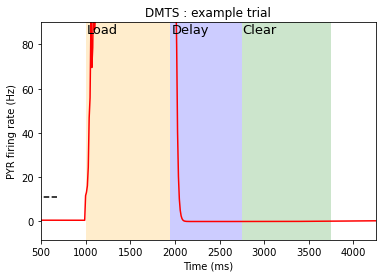

In [62]:
dmts.plot_trials(0)

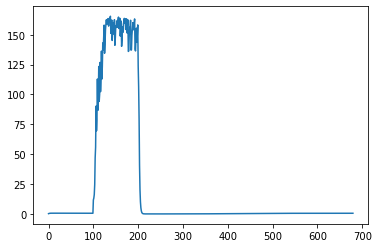

In [60]:
sim = ccm.simulations[0]
plt.plot(sim.traces[0])
plt.show()

In [61]:
ccm.S

[array([0.53532235, 0.96240103, 0.83785748, 0.4766874 ]),
 array([0.61717318, 0.33423745, 3.29694262, 4.53982974]),
 array([10.91154219,  2.92078976,  8.64375169,  7.50461372]),
 array([ 77.00859538,  40.26411026,   4.16127548, 123.8334748 ])]

In [7]:
ccm.S

[array([0.6032665 , 0.87046909, 0.50015718, 0.37357392]),
 array([0.61717318, 0.33423745, 3.29694262, 4.53982974]),
 array([10.91154219,  2.92078976,  8.64375169,  7.50461372])]

## INs' Iext impact on memory stats

In [38]:
task_prm = [60, 1, (1.850,1.950), (2.65, 2.75), (3.65,3.75)]

In [39]:
## SOM

dof_som = dof.clone()
load_som = []
delay_som = []
dof_som[16] -= 2.5

print(dof_som[16])

for i in tqdm(range(100)):
    ccm = CCM(dof_som, mod_prm, sim_prm)
    dmts = DMTS(ccm, task_prm)
    load_som.append(dmts.loadings/dmts.nb_trials)
    delay_som.append(dmts.maintenances/dmts.nb_trials)
    dof_som[16] += 0.05

tensor(1.1000, dtype=torch.float64)


In [86]:
## VIP

dof_vip = dof.clone()
load_vip = []
delay_vip = []
dof_vip[17] -= 2.5

for i in tqdm(range(100)):
    ccm = CCM(dof_vip, mod_prm, sim_prm)
    dmts = DMTS(ccm, task_prm)
    load_vip.append(dmts.loadings/dmts.nb_trials)
    delay_vip.append(dmts.maintenances/dmts.nb_trials)
    dof_vip[17] += 0.05

In [89]:
## PV

dof_pv = dof.clone()
load_pv = []
delay_pv = []
dof_pv[15] -= 2.5

for i in tqdm(range(100)):
    ccm = CCM(dof_pv, mod_prm, sim_prm)
    dmts = DMTS(ccm, task_prm)
    load_pv.append(dmts.loadings/dmts.nb_trials)
    delay_pv.append(dmts.maintenances/dmts.nb_trials)
    dof_pv[15] += 0.05

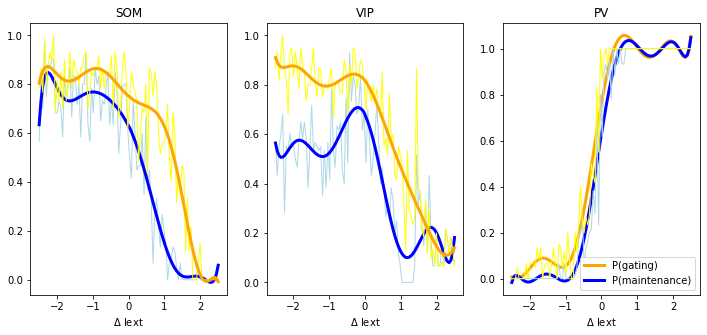

In [8]:
from scipy.signal import savgol_filter

x = np.linspace(-2.5,2.5,100)
y = delay_som

delay_som_hat = savgol_filter(delay_som, 99, 9) # window size 99, polynomial order 3
load_som_hat = savgol_filter(load_som, 99, 9)
delay_vip_hat = savgol_filter(delay_vip, 99, 9)
load_vip_hat = savgol_filter(load_vip, 99, 9)
delay_pv_hat = savgol_filter(delay_pv, 99, 9)
load_pv_hat = savgol_filter(load_pv, 99, 9)

fig, ax = plt.subplots(1, 3, sharex = True, figsize = (12, 5))

ax[0].plot(x, delay_som, color = 'lightblue', linewidth = 1)
ax[0].plot(x, delay_som_hat, color = 'blue', linewidth = 3)
ax[0].plot(x, load_som, color = 'yellow', linewidth = 1)
ax[0].plot(x, load_som_hat, color = 'orange', linewidth = 3)
ax[0].set(xlabel = r'$\Delta$ Iext', title = 'SOM')
#ax[0].vlines(x= 0, ymin = 0, ymax = 1, color = 'lightgrey')

ax[1].plot(x, delay_vip, color = 'lightblue', linewidth = 1)
ax[1].plot(x, delay_vip_hat, color = 'blue', linewidth = 3)
ax[1].plot(x, load_vip, color = 'yellow', linewidth = 1)
ax[1].plot(x, load_vip_hat, color = 'orange', linewidth = 3)
ax[1].set(xlabel = r'$\Delta$ Iext', title = 'VIP')
#ax[1].vlines(x= 0, ymin = 0, ymax = 1, color = 'lightgrey')

ax[2].plot(x, load_pv_hat, color = 'orange', linewidth = 3)
ax[2].plot(x, delay_pv_hat, color = 'blue', linewidth = 3)
ax[2].plot(x, delay_pv, color = 'lightblue', linewidth = 1)
ax[2].plot(x, load_pv, color = 'yellow', linewidth = 1)
ax[2].set(xlabel = r'$\Delta$ Iext', title = 'PV')
#ax[2].vlines(x= 0, ymin = 0, ymax = 1, color = 'lightgrey')
ax[2].legend(('P(gating)','P(maintenance)'), loc = 'lower right')

plt.show()

In [11]:
'''
x = np.linspace(1, 100, 100)
y = 50*np.cos(x)

plt.rcParams['axes.facecolor'] = 'white'

fig, ax = plt.subplots()
ax.plot(x)
ax.plot(y)

#ax.vlines(x = [5,10], ymin  = -50, ymax = 100, color = 'r') 
#ax.vlines(x = [30,35], ymin  = -50, ymax = 100, color = 'b') 
#ax.vlines(x = [50,60], ymin  = -50, ymax = 100, color = 'g') 
ax.hlines(y = 20, xmin = 0, xmax = len(x), linestyle = 'dashed')

ax.axvspan(5, 10, facecolor='b', alpha=0.2)

ax.set(title = 'DMTS - Example trial', xlabel = 'Time', ylabel = 'PYR firing rate')
#ax.legend(['red', 'blue', 'green'])
ax.text(20, 80, 'an equation: $E=mc^2$', fontsize=13)

plt.show()
'''

"\nx = np.linspace(1, 100, 100)\ny = 50*np.cos(x)\n\nplt.rcParams['axes.facecolor'] = 'white'\n\nfig, ax = plt.subplots()\nax.plot(x)\nax.plot(y)\n\n#ax.vlines(x = [5,10], ymin  = -50, ymax = 100, color = 'r') \n#ax.vlines(x = [30,35], ymin  = -50, ymax = 100, color = 'b') \n#ax.vlines(x = [50,60], ymin  = -50, ymax = 100, color = 'g') \nax.hlines(y = 20, xmin = 0, xmax = len(x), linestyle = 'dashed')\n\nax.axvspan(5, 10, facecolor='b', alpha=0.2)\n\nax.set(title = 'DMTS - Example trial', xlabel = 'Time', ylabel = 'PYR firing rate')\n#ax.legend(['red', 'blue', 'green'])\nax.text(20, 80, 'an equation: $E=mc^2$', fontsize=13)\n\nplt.show()\n"

In [2]:
load_som =[0.7833333333333333, 0.8666666666666667, 0.7666666666666667, 0.9833333333333333, 0.8, 0.8833333333333333, 0.9333333333333333, 0.9, 1.0, 0.6833333333333333, 0.8166666666666667, 0.7333333333333333, 0.85, 0.7, 0.9, 0.7333333333333333, 0.8, 0.9333333333333333, 0.7833333333333333, 0.9, 0.8666666666666667, 0.85, 0.8, 0.8666666666666667, 0.8666666666666667, 0.9166666666666666, 0.9333333333333333, 0.7, 0.7666666666666667, 0.85, 0.8333333333333334, 0.8666666666666667, 0.8666666666666667, 0.9166666666666666, 0.7833333333333333, 0.8666666666666667, 0.7833333333333333, 0.85, 0.85, 0.8333333333333334, 0.9166666666666666, 0.7, 0.9333333333333333, 0.8666666666666667, 0.6666666666666666, 0.7, 0.8666666666666667, 0.9333333333333333, 0.8666666666666667, 0.6166666666666667, 0.7166666666666667, 0.85, 0.8, 0.7666666666666667, 0.7333333333333333, 0.48333333333333334, 0.6, 0.7, 0.6833333333333333, 0.8, 0.43333333333333335, 0.8666666666666667, 0.85, 0.75, 0.85, 0.8, 0.6, 0.5166666666666667, 0.55, 0.5666666666666667, 0.5833333333333334, 0.7166666666666667, 0.5, 0.4, 0.6833333333333333, 0.6, 0.31666666666666665, 0.43333333333333335, 0.35, 0.4666666666666667, 0.45, 0.11666666666666667, 0.3333333333333333, 0.11666666666666667, 0.21666666666666667, 0.0, 0.0, 0.0, 0.06666666666666667, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

delay_som = [0.5666666666666667, 0.8166666666666667, 0.7, 0.9833333333333333, 0.75, 0.8833333333333333, 0.8666666666666667, 0.9, 0.9, 0.6833333333333333, 0.6833333333333333, 0.7333333333333333, 0.7, 0.5833333333333334, 0.8333333333333334, 0.7333333333333333, 0.8, 0.8666666666666667, 0.6666666666666666, 0.8333333333333334, 0.8333333333333334, 0.7166666666666667, 0.8, 0.5833333333333334, 0.8, 0.8, 0.9333333333333333, 0.6333333333333333, 0.5666666666666667, 0.7833333333333333, 0.6833333333333333, 0.8666666666666667, 0.8, 0.8333333333333334, 0.65, 0.7333333333333333, 0.7166666666666667, 0.7833333333333333, 0.85, 0.6333333333333333, 0.7333333333333333, 0.6333333333333333, 0.85, 0.7833333333333333, 0.5166666666666667, 0.6333333333333333, 0.7833333333333333, 0.8, 0.8, 0.6166666666666667, 0.5, 0.4166666666666667, 0.7333333333333333, 0.6, 0.45, 0.4666666666666667, 0.4666666666666667, 0.6, 0.35, 0.6666666666666666, 0.36666666666666664, 0.45, 0.31666666666666665, 0.06666666666666667, 0.2833333333333333, 0.3333333333333333, 0.21666666666666667, 0.13333333333333333, 0.26666666666666666, 0.2, 0.15, 0.0, 0.06666666666666667, 0.08333333333333333, 0.13333333333333333, 0.11666666666666667, 0.05, 0.0, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667]

load_vip = [0.8666666666666667, 0.9333333333333333, 0.8166666666666667, 0.9333333333333333, 1.0, 0.8666666666666667, 0.8166666666666667, 0.6833333333333333, 0.9333333333333333, 0.95, 0.8333333333333334, 0.9333333333333333, 0.8666666666666667, 0.7833333333333333, 0.95, 0.8833333333333333, 0.85, 0.7333333333333333, 0.8, 0.8, 0.8666666666666667, 0.95, 0.8, 0.75, 0.8666666666666667, 0.8666666666666667, 0.75, 0.8, 0.8, 0.7833333333333333, 0.8333333333333334, 0.8666666666666667, 0.6666666666666666, 0.8, 0.8166666666666667, 0.8, 0.7666666666666667, 0.7666666666666667, 0.9, 0.8666666666666667, 0.6833333333333333, 0.8833333333333333, 0.8, 0.95, 0.9333333333333333, 0.7833333333333333, 0.8333333333333334, 0.9, 0.8833333333333333, 0.8166666666666667, 0.7, 0.8166666666666667, 0.7666666666666667, 0.7333333333333333, 0.8, 0.7333333333333333, 0.7833333333333333, 0.7, 0.6666666666666666, 0.85, 0.55, 0.5833333333333334, 0.5166666666666667, 0.7666666666666667, 0.5833333333333334, 0.6, 0.43333333333333335, 0.4166666666666667, 0.55, 0.5166666666666667, 0.48333333333333334, 0.31666666666666665, 0.13333333333333333, 0.5333333333333333, 0.3, 0.26666666666666666, 0.23333333333333334, 0.26666666666666666, 0.8666666666666667, 0.38333333333333336, 0.36666666666666664, 0.21666666666666667, 0.18333333333333332, 0.3333333333333333, 0.11666666666666667, 0.3, 0.1, 0.13333333333333333, 0.06666666666666667, 0.2, 0.06666666666666667, 0.06666666666666667, 0.08333333333333333, 0.06666666666666667, 0.21666666666666667, 0.18333333333333332, 0.11666666666666667, 0.18333333333333332, 0.13333333333333333, 0.06666666666666667]

delay_vip = [0.5666666666666667, 0.43333333333333335, 0.55, 0.6, 0.6833333333333333, 0.2833333333333333, 0.55, 0.5333333333333333, 0.6, 0.55, 0.55, 0.5, 0.4666666666666667, 0.5666666666666667, 0.65, 0.5833333333333334, 0.65, 0.5833333333333334, 0.38333333333333336, 0.5333333333333333, 0.7166666666666667, 0.5333333333333333, 0.5666666666666667, 0.55, 0.5333333333333333, 0.55, 0.35, 0.5333333333333333, 0.38333333333333336, 0.5666666666666667, 0.4166666666666667, 0.7833333333333333, 0.5333333333333333, 0.4666666666666667, 0.6333333333333333, 0.6166666666666667, 0.65, 0.45, 0.4, 0.75, 0.48333333333333334, 0.9333333333333333, 0.7333333333333333, 0.8333333333333334, 0.8, 0.6833333333333333, 0.7, 0.8333333333333334, 0.6166666666666667, 0.6833333333333333, 0.48333333333333334, 0.7, 0.5666666666666667, 0.43333333333333335, 0.5, 0.6, 0.7166666666666667, 0.5833333333333334, 0.4, 0.4666666666666667, 0.38333333333333336, 0.26666666666666666, 0.31666666666666665, 0.25, 0.38333333333333336, 0.3333333333333333, 0.2, 0.25, 0.11666666666666667, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.5166666666666667, 0.31666666666666665, 0.36666666666666664, 0.21666666666666667, 0.15, 0.3333333333333333, 0.11666666666666667, 0.43333333333333335, 0.16666666666666666, 0.06666666666666667, 0.06666666666666667, 0.2, 0.06666666666666667, 0.06666666666666667, 0.15, 0.06666666666666667, 0.21666666666666667, 0.18333333333333332, 0.11666666666666667, 0.18333333333333332, 0.13333333333333333, 0.06666666666666667]

load_pv = [0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.0, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.05, 0.13333333333333333, 0.08333333333333333, 0.13333333333333333, 0.0, 0.05, 0.06666666666666667, 0.06666666666666667, 0.0, 0.06666666666666667, 0.13333333333333333, 0.06666666666666667, 0.0, 0.15, 0.13333333333333333, 0.05, 0.11666666666666667, 0.016666666666666666, 0.2, 0.06666666666666667, 0.0, 0.0, 0.2, 0.11666666666666667, 0.25, 0.4, 0.25, 0.2, 0.26666666666666666, 0.23333333333333334, 0.2833333333333333, 0.5, 0.45, 0.4166666666666667, 0.8333333333333334, 0.55, 1.0, 0.8666666666666667, 0.9666666666666667, 1.0, 0.9333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

delay_pv = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.0, 0.0, 0.06666666666666667, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016666666666666666, 0.05, 0.18333333333333332, 0.2, 0.25, 0.06666666666666667, 0.13333333333333333, 0.16666666666666666, 0.2, 0.21666666666666667, 0.38333333333333336, 0.2833333333333333, 0.7, 0.23333333333333334, 0.8, 0.6166666666666667, 0.9, 0.9333333333333333, 0.8666666666666667, 0.95, 0.7833333333333333, 1.0, 0.8833333333333333, 1.0, 0.9333333333333333, 1.0, 0.9333333333333333, 0.9333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

### PV and bistability ?

In [13]:
dof_pv = dof.clone()
equilibria = []
up = []
dof_pv[15] -= 2.5

for i in tqdm(range(20)):
    ccm = CCM(dof_pv, mod_prm, sim_prm)
    equilibria.append(len(ccm.S))
    up.append(ccm.S[-1][0])
    dof_pv[15] += 0.25

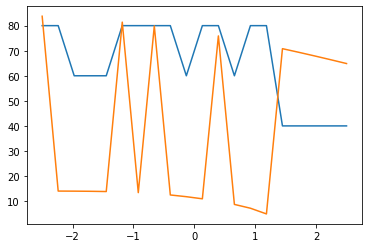

In [22]:
plt.plot(np.linspace(-2.5,2.5,20), [20*i for i in equilibria])
plt.plot(np.linspace(-2.5,2.5,20), up)
plt.show()

In [23]:
print(delay_som[50], delay_pv[50], delay_vip[50])

0.5 0.6166666666666667 0.48333333333333334
